In [1]:
import logging
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from pyeed import Pyeed

2025-08-14 07:56:29.900 | INFO     | pyeed.embeddings.processor:_initialize_devices:46 - Initialized 3 GPU device(s): [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2)]


In [2]:
path_to_data_blast = "/home/nab/Niklas/TEM-lactamase/data/003_data_pull/blast_data_dna/2025-01-19_12-37-48"


load_dotenv()
password = os.getenv("NEO4J_NIKLAS_TEM_THREE")
if password is None:
    raise ValueError("KEY is not set in the .env file.")


logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
LOGGER = logging.getLogger(__name__)


uri = "bolt://129.69.129.130:2137"
user = "neo4j"
eedb = Pyeed(uri, user=user, password=password)
# eedb.db.initialize_db_constraints(user, password)

📡 Connected to database.


     Query ID      Subject ID  % Identity  Alignment Length  Mismatches  \
0  CAB92324.1  WP_063864914.1      99.650               286           1   
1  CAB92324.1  WP_063864915.1      99.301               286           2   
2  CAB92324.1      ARF20220.1      99.301               286           2   
3  CAB92324.1  WP_032490155.1      99.301               286           2   
4  CAB92324.1    HBX5204678.1      98.951               286           3   

   Gap Opens  Query Start  Query End  Subject Start  Subject End  E-value  \
0          0            1        286              1          286      0.0   
1          0            1        286              1          286      0.0   
2          0            1        286              1          286      0.0   
3          0            1        286              1          286      0.0   
4          0            1        286              1          286      0.0   

   Bit Score  
0        588  
1        587  
2        587  
3        586  
4        58

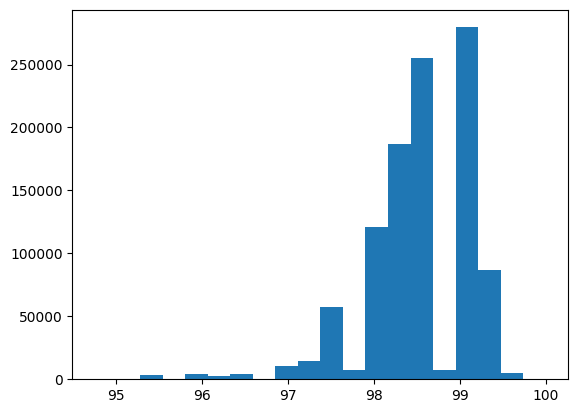

In [3]:
path_to_data_blast_protein = "/home/nab/Niklas/TEM-lactamase/data/003_data_pull/blast_data/combined_data_blast_5000_tem_209"


# read the csv file
df_protein = pd.read_csv(
    os.path.join(path_to_data_blast_protein, "combined_data_blast_5000_tem_209.csv")
)
print(df_protein.head())
print(len(df_protein))
# columns are: Query ID, Subject ID, E-value, Identity, Alignment Length, Mismatches, Gap Opens, Q. Start, Q. End, S. Start, S. End, E-value, Bit Score

# how many unique subject id are there?
unique_subject_ids = df_protein["Subject ID"].unique()
print(f"Number of unique subject ids: {len(unique_subject_ids)}")
print(f"Number of unique query ids: {len(df_protein['Query ID'].unique())}")


# show a histogram of the identity of the proteins only the unique values of the Subject ID
plt.hist(df_protein["% Identity"], bins=20)
plt.show()


In [4]:
df_dna = pd.read_csv(
    os.path.join(path_to_data_blast, "combined_data_blast_5000_dna_tem_209.csv")
)
print(df_dna.head())
print(len(df_dna))
# columns are: Query ID, Subject ID, E-value, Identity, Alignment Length, Mismatches, Gap Opens, Q. Start, Q. End, S. Start, S. End, E-value, Bit Score
print(f"Number of unique query ids: {len(df_dna['Query ID'].unique())}")
print(f"Number of unique subject ids: {len(df_dna['Subject ID'].unique())}")
print(df_dna['Query ID'].unique().tolist())

            Query ID  Subject ID  % Identity  Alignment Length  Mismatches  \
0  DAGOQK010000132.1  MK941846.1     100.000                38           0   
1  DAGOQK010000132.1  CP040912.1      99.907              1070           1   
2  DAGOQK010000132.1  CP040912.1     100.000                38           0   
3  DAGOQK010000132.1  CP044028.1      99.907              1070           1   
4  DAGOQK010000132.1  CP044028.1     100.000                38           0   

   Gap Opens  Query Start  Query End  Subject Start  Subject End  \
0          0         1032       1069          51319        51356   
1          0            1       1070          48827        49896   
2          0         1032       1069          44986        44949   
3          0            1       1070           3705         4774   
4          0         1032       1069          43060        43023   

        E-value  Bit Score  
0  9.350000e-07       71.3  
1  0.000000e+00     1971.0  
2  9.350000e-07       71.3  
3  0.0

In [5]:
# find out how many proteins are there which are connected to a DNA sequence
query_ids_of_dna_connected_to_proteins = """
    MATCH (d:DNA)-[:ENCODES]->(p:Protein) RETURN d.accession_id
"""
query_ids_of_dna_connected_to_proteins = eedb.db.execute_read(
    query_ids_of_dna_connected_to_proteins
)
print(
    f"Number of DNA sequences connected to a protein: {len(query_ids_of_dna_connected_to_proteins)}"
)

Number of DNA sequences connected to a protein: 53442


In [6]:
# find total number of proteins
query_total_number_of_proteins = """
    MATCH (p:Protein) RETURN count(p)
"""
total_number_of_proteins = eedb.db.execute_read(query_total_number_of_proteins)
print(f"Total number of proteins: {total_number_of_proteins[0]['count(p)']}")

Total number of proteins: 22513


In [7]:
query = "MATCH (p:Protein) RETURN p.embedding LIMIT 10"

result = eedb.db.execute_write(query)

print(np.array(result[2]['p.embedding']).shape)

(960,)


In [8]:
# count the number of protein with a length flag of 1
query_number_of_proteins_with_length_flag_1 = """
    MATCH (p:Protein) WHERE p.length_flag = 1 RETURN count(p)
"""
number_of_proteins_with_length_flag_1 = eedb.db.execute_read(query_number_of_proteins_with_length_flag_1)
print(f"Number of proteins with length flag 1: {number_of_proteins_with_length_flag_1[0]['count(p)']}")

Number of proteins with length flag 1: 10721


In [9]:
# return number of unique mutation relationships between proteins
query_number_of_unique_mutation_relationships_between_proteins = """
    MATCH (p1:Protein)-[:MUTATION]->(p2:Protein)
    RETURN count(DISTINCT p1)
"""
number_of_unique_mutation_relationships_between_proteins = eedb.db.execute_read(query_number_of_unique_mutation_relationships_between_proteins)
print(f"Number of unique mutation relationships between proteins: {number_of_unique_mutation_relationships_between_proteins[0]['count(DISTINCT p1)']}")

Number of unique mutation relationships between proteins: 10708


In [ ]:
# count number of DNA connected to region with annotation coding seqeunce which is conncted to antohter reagion with the same annotation and then dna
query_number_of_dna_connected_to_coding_sequence_region = """
    MATCH (d1:DNA)-[:HAS_REGION]-(r1:Region) WHERE r1.annotation = "coding sequence"
    MATCH (d2:DNA)-[:HAS_REGION]-(r2:Region) WHERE r2.annotation = "coding sequence"
    MATCH (r1)-[rel_mut:MUTATION]-(r2)
    RETURN count(DISTINCT rel_mut)
"""
number_of_dna_connected_to_coding_sequence_region = eedb.db.execute_read(
    query_number_of_dna_connected_to_coding_sequence_region
)

print(f"Number: {number_of_dna_connected_to_coding_sequence_region[0]['count(DISTINCT rel_mut)']}")
# Number: 5_642_848
# Number: 9_951_001 # 14_08_2025


Number: 9951001


In [11]:
query = """
MATCH ()-[rel_mut:MUTATION]->()
WHERE labels(startNode(rel_mut)) = ['Protein'] AND labels(endNode(rel_mut)) = ['Protein']
RETURN count(rel_mut)
"""

result = eedb.db.execute_read(query)

print(f"Number: {result[0]['count(rel_mut)']}")

Number: 54574206


In [12]:

query = """
MATCH ()-[rel_mut:MUTATION]->()
WHERE labels(startNode(rel_mut)) = ['Region'] AND labels(endNode(rel_mut)) = ['Region']
RETURN count(rel_mut)
"""

result = eedb.db.execute_read(query)

print(f"Number: {result[0]['count(rel_mut)']}")

Number: 9951001


In [13]:
# count number of numtation relationships outgoing from the region node with the elementId 4:d0fe8add-d91b-4dda-9dd3-7b5b2e4fbfb9:23235041
query = """
MATCH (r1:Region) WHERE elementId(r1) = '4:d0fe8add-d91b-4dda-9dd3-7b5b2e4fbfb9:23235041'
MATCH (r2:Region)-[:MUTATION]-(r1)
RETURN count(DISTINCT r2)
"""

result = eedb.db.execute_read(query)

print(result)

[{'count(DISTINCT r2)': 8718}]


In [14]:
# count the number of protein with and embedding not none
query_number_of_proteins_with_embedding_not_none = """
    MATCH (p:Protein) WHERE p.embedding IS NOT NULL RETURN count(p)
"""
number_of_proteins_with_embedding_not_none = eedb.db.execute_read(
    query_number_of_proteins_with_embedding_not_none
)
print(f"Number of proteins with embedding not none: {number_of_proteins_with_embedding_not_none[0]['count(p)']}")

Number of proteins with embedding not none: 22513


In [15]:
# find total number of DNA sequences
query_total_number_of_dna_sequences = """
    MATCH (d:DNA) RETURN count(d)
"""
total_number_of_dna_sequences = eedb.db.execute_read(
    query_total_number_of_dna_sequences
)
print(f"Total number of DNA sequences: {total_number_of_dna_sequences[0]['count(d)']}")

Total number of DNA sequences: 53218


Number of Protein sequences with identical IDs: 148
dict_keys(['AJH76980.1', 'WP_063859788.1', 'AAC76364.1', 'AAC75291.1', 'AAC76055.1', 'WP_063864914.1', 'WP_063864915.1', 'WP_032490155.1', 'WP_063864885.1', 'WP_094353585.1', 'WP_063864855.1', 'WP_032492108.1', 'WP_032490101.1', 'WP_032489614.1', 'WP_063864808.1', 'WP_063864911.1', 'WP_077064889.1', 'WP_063864793.1', 'WP_063864876.1', 'WP_063864916.1', 'WP_033560332.1', 'WP_032494237.1', 'WP_063864801.1', 'WP_063864875.1', 'AAL21173.1', 'WP_000072047.1', 'AAC72362.1', 'AAK82652.1', 'AAM61952.1', 'AAM61953.1', 'AAM52207.1', 'AAM52215.1', 'AAM28884.1', 'AAT46413.1', 'AAW66604.1', 'AAS89982.1', 'AAS89983.1', 'AAS89984.1', 'AAN04881.1', 'AAB39956.1', 'AAQ01671.1', 'AAQ93490.1', 'AAQ93491.1', 'AAT46414.1', 'AAT45742.1', 'AAR89358.1', 'AAR89359.1', 'CAG34105.1', 'CAI29263.1', 'AAR10958.1', 'AAS19171.1', 'AAS79107.1', 'CAG25427.1', 'AAV83795.1', 'CAJ32372.1', 'ABC96711.1', 'CAJ66089.1', 'ABI74448.1', 'ABI74447.1', 'AGA83484.1', 'ACO07310.1',

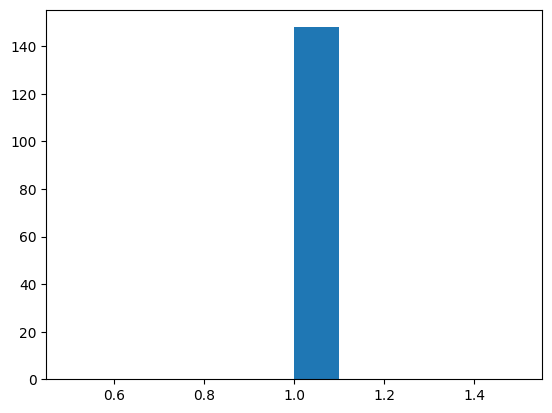

In [16]:
query_find_number_dna_of_identical_ids = """
    MATCH (p:Protein) WHERE p.IdenticalIds IS NOT NULL RETURN p.accession_id, p.IdenticalIds
"""
number_dna_of_identical_ids = eedb.db.execute_read(query_find_number_dna_of_identical_ids)
print(f"Number of Protein sequences with identical IDs: {len(number_dna_of_identical_ids)}")

data_dic = {}
total_identical_ids = 0
for item in number_dna_of_identical_ids:
        data_dic[item['p.accession_id']] = list(item['p.IdenticalIds'])
        total_identical_ids += len(item['p.IdenticalIds'])

print(data_dic.keys())
print(data_dic)
print(f"Total number of identical ids: {total_identical_ids}")
data = [len(data_dic[item]) for item in data_dic]
print(data)
# histogram of list length of data_dic
plt.hist(data)
plt.show()

Number of DNA sequences with identical IDs: 0
dict_keys([])
[]


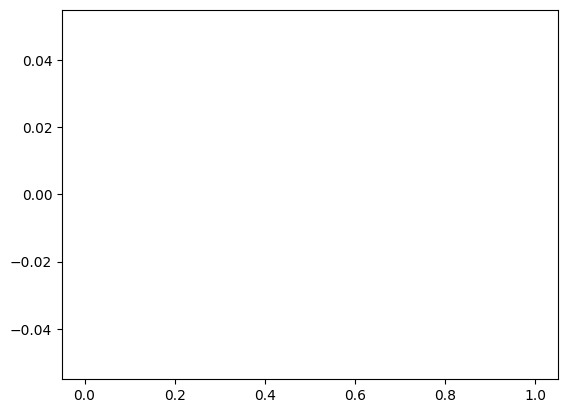

In [17]:
query_find_number_dna_of_identical_ids = """
    MATCH (d:DNA) WHERE d.IdenticalIds IS NOT NULL RETURN d.accession_id, d.IdenticalIds
"""
number_dna_of_identical_ids = eedb.db.execute_read(query_find_number_dna_of_identical_ids)
print(f"Number of DNA sequences with identical IDs: {len(number_dna_of_identical_ids)}")

data_dic = {}

for item in number_dna_of_identical_ids:
        data_dic[item['d.accession_id']] = list(item['d.IdenticalIds'])

print(data_dic.keys())
data = [len(data_dic[item]) for item in data_dic]
print(data)
# histogram of list length of data_dic
plt.hist(data)
plt.show()


In [18]:
# find the number of DNA sequences which are not connected to a protein return count unique of the dna
query_number_of_dna_sequences_without_protein_connecting_to_them = """
    MATCH (d:DNA) WHERE NOT (d)-[:ENCODES]->(:Protein) RETURN count(DISTINCT d)
"""
number_of_dna_sequences_without_protein_connecting_to_them = eedb.db.execute_read(
    query_number_of_dna_sequences_without_protein_connecting_to_them
)
print(
    f"Number of DNA sequences without protein: {number_of_dna_sequences_without_protein_connecting_to_them}"
)

Number of DNA sequences without protein: [{'count(DISTINCT d)': 0}]


In [19]:
# find the number of DNA sequences which are not connected to a protein
query_number_of_dna_sequences_without_protein_connecting_to_them = """
    MATCH (p:Protein) WHERE NOT (:DNA)-[:ENCODES]->(p) RETURN count(DISTINCT p)
"""
number_of_dna_sequences_without_protein_connecting_to_them = eedb.db.execute_read(
    query_number_of_dna_sequences_without_protein_connecting_to_them
)
print(
    f"Number of Proteins without DNA: {number_of_dna_sequences_without_protein_connecting_to_them[0]['count(DISTINCT p)']}"
)

Number of Proteins without DNA: 4287


In [20]:
# find the number of proteins which are standalone not conncted to DNA, mean no DNA connects to them
query_number_of_proteins_without_dna_connecting_to_them = """
    MATCH (p:Protein) WHERE NOT (:DNA)-[:ENCODES]->(p) RETURN count(p)
"""
number_of_proteins_without_dna_connecting_to_them = eedb.db.execute_read(
    query_number_of_proteins_without_dna_connecting_to_them
)
print(
    f"Number of proteins without DNA: {number_of_proteins_without_dna_connecting_to_them[0]['count(p)']}"
)

Number of proteins without DNA: 4287


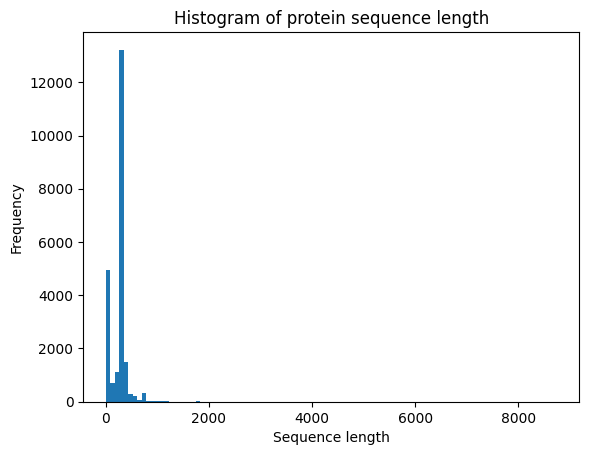

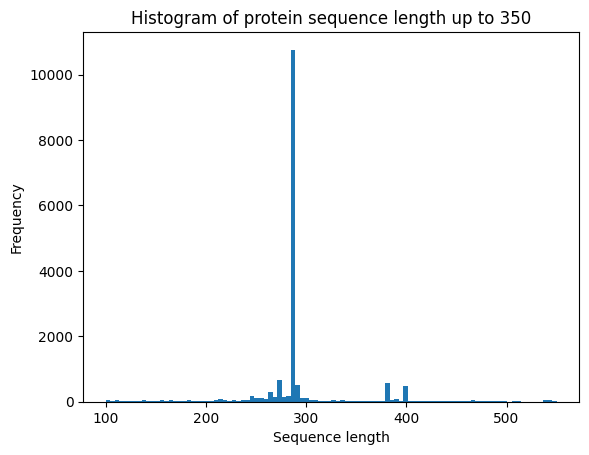

In [21]:
# i want histogram frequency of the sequence length of the proteins, it is in the database as a property of the protein seq_length
query_histogram_frequency_of_protein_sequence_length = """
    MATCH (p:Protein) WHERE p.seq_length IS NOT NULL RETURN p.seq_length
"""
histogram_frequency_of_protein_sequence_length = eedb.db.execute_read(
    query_histogram_frequency_of_protein_sequence_length
)
# convert the list of dictionaries to a list of numpy arrays
histogram_frequency_of_protein_sequence_length = [
    np.array(item["p.seq_length"])
    for item in histogram_frequency_of_protein_sequence_length
]

# plot the histogram
plt.hist(histogram_frequency_of_protein_sequence_length, bins=100)
plt.title("Histogram of protein sequence length")
plt.xlabel("Sequence length")
plt.ylabel("Frequency")
# plt.savefig("histogram_frequency_of_protein_sequence_length.png")
plt.show()
plt.close()

# make second historgram just up the the seq length of 350
plt.hist(histogram_frequency_of_protein_sequence_length, bins=100, range=(100, 550))
plt.title("Histogram of protein sequence length up to 350")
plt.xlabel("Sequence length")
plt.ylabel("Frequency")
# plt.savefig("histogram_frequency_of_protein_sequence_length_up_to_350.png")
plt.show()
plt.close()

In [22]:
# estimate the number of protein in the sequence length of plus and minus of 286
base_length = 286
delta_length = 50
# get the number of proteins in the range
query_number_of_proteins_in_range = f"""
    MATCH (p:Protein) WHERE p.seq_length >= {base_length - delta_length} AND p.seq_length <= {base_length + delta_length} RETURN count(p)
"""
number_of_proteins_in_range = eedb.db.execute_read(query_number_of_proteins_in_range)
print(f"Number of proteins in the range: {number_of_proteins_in_range[0]['count(p)']}")


Number of proteins in the range: 13713


2025-08-14 07:59:32,150 - WARNING - Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\n    MATCH (p:Protein)\n    OPTIONAL MATCH (d:DNA)-[:ENCODES]->(p)\n    WITH p, COUNT(d) as num_connections\n    RETURN num_connections, p.accession_id\n'


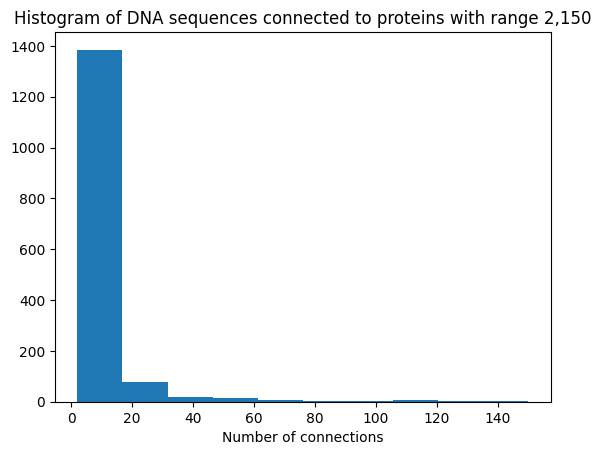

2025-08-14 07:59:32,394 - WARNING - Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\n    MATCH (p:Protein)\n    OPTIONAL MATCH (p)-[:ENCODES]-(d:DNA)\n    WITH p, COUNT(d) as num_connections\n    RETURN p.accession_id, num_connections\n    ORDER BY num_connections DESC\n    LIMIT 10\n'


IDs of DNA sequences with the most connections to proteins: [{'p.accession_id': 'a4c886b2-544e-4560-bb87-374f2bd5e65e', 'num_connections': 6824}, {'p.accession_id': 'CAD09800.1', 'num_connections': 2591}, {'p.accession_id': 'WP_033560332.1', 'num_connections': 2051}, {'p.accession_id': 'f8cbdda8-e86c-413d-9850-faef49eaa345', 'num_connections': 1773}, {'p.accession_id': '083d58b3-f881-493c-8096-846207537607', 'num_connections': 1512}, {'p.accession_id': 'CAA73933.1', 'num_connections': 1450}, {'p.accession_id': 'ARF21576.1', 'num_connections': 887}, {'p.accession_id': 'ARF31154.1', 'num_connections': 794}, {'p.accession_id': 'ARF27305.1', 'num_connections': 747}, {'p.accession_id': 'WP_032492108.1', 'num_connections': 636}]


In [23]:
# a histogram that show how many DNA nodes a protein has
# while keeping in mind that DNA - ENCODES -> Protein
# check for all proteins which might have multiple DNA sequences encoding them
query_histogram_frequency_of_protein_connections_to_dna_sequence = """
    MATCH (p:Protein)
    OPTIONAL MATCH (d:DNA)-[:ENCODES]->(p)
    WITH p, COUNT(d) as num_connections
    RETURN num_connections, p.accession_id
"""
histogram_frequency_of_protein_connections_to_dna_sequence = eedb.db.execute_read(
    query_histogram_frequency_of_protein_connections_to_dna_sequence
)

# convert the list of dictionaries to a list of numpy arrays
histogram_frequency_of_protein_connections_to_dna_sequence = [
    np.array(item["num_connections"])
    for item in histogram_frequency_of_protein_connections_to_dna_sequence
]

# plot the histogram
plt.hist(histogram_frequency_of_protein_connections_to_dna_sequence, bins=10, range=(2, 150))
plt.title("Histogram of DNA sequences connected to proteins with range 2,150")
plt.xlabel("Number of connections")
plt.show()

# the ids with the most connections to proteins
# print the 10 most connection the number and the ids
query_ids_of_dna_sequences_with_most_connections_to_proteins = """
    MATCH (p:Protein)
    OPTIONAL MATCH (p)-[:ENCODES]-(d:DNA)
    WITH p, COUNT(d) as num_connections
    RETURN p.accession_id, num_connections
    ORDER BY num_connections DESC
    LIMIT 10
"""
ids_of_dna_sequences_with_most_connections_to_proteins = eedb.db.execute_read(
    query_ids_of_dna_sequences_with_most_connections_to_proteins
)
print(
    f"IDs of DNA sequences with the most connections to proteins: {ids_of_dna_sequences_with_most_connections_to_proteins}"
)

IDs of DNA sequences with the most connections to proteins: [{'d.accession_id': 'AE004091.2', 'num_connections': 37}, {'d.accession_id': 'U00096.3', 'num_connections': 33}, {'d.accession_id': 'AP009048.1', 'num_connections': 12}, {'d.accession_id': 'AE006468.2', 'num_connections': 11}, {'d.accession_id': 'BX571856.1', 'num_connections': 10}, {'d.accession_id': 'M97297.1', 'num_connections': 7}, {'d.accession_id': 'AL009126.3', 'num_connections': 6}, {'d.accession_id': 'AE002098.2', 'num_connections': 5}, {'d.accession_id': 'BA000007.3', 'num_connections': 5}, {'d.accession_id': 'AL123456.3', 'num_connections': 5}]


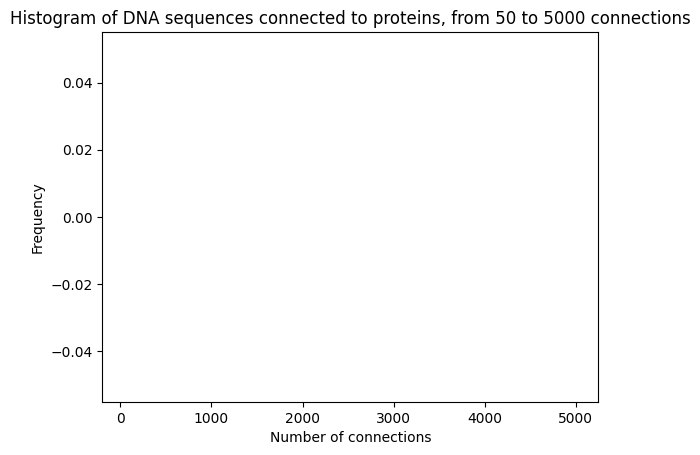

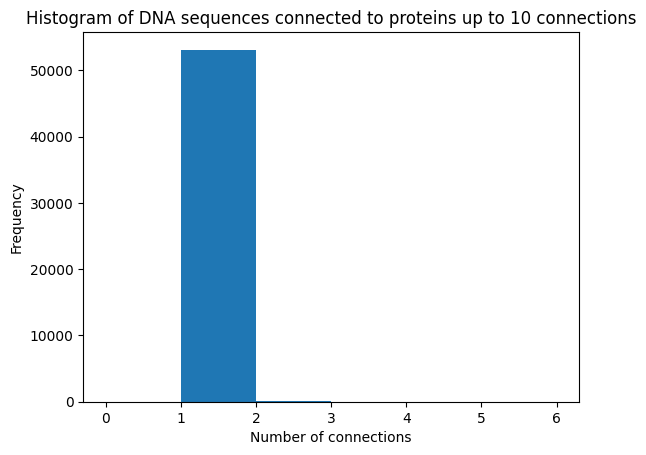

In [24]:
# a histogram which shows the number of connections a single DNA sequence has to other Proteins
# to this for each DNA sequence in the database, count the number of proteins it connects to
query_histogram_frequency_of_protein_connections_to_dna_sequence = """
    MATCH (d:DNA)
    OPTIONAL MATCH (d)-[:ENCODES]->(p:Protein)
    WITH d, COUNT(p) as num_connections
    RETURN num_connections, COUNT(d) as num_dnas, d.accession_id
    ORDER BY num_connections
"""
histogram_frequency_of_protein_connections_to_dna_sequence = eedb.db.execute_read(
    query_histogram_frequency_of_protein_connections_to_dna_sequence
)

# return the ids for 10 DNA sequences with the most connections to proteins
query_ids_of_dna_sequences_with_most_connections_to_proteins = """
    MATCH (d:DNA)
    OPTIONAL MATCH (d)-[:ENCODES]->(p:Protein)
    WITH d, COUNT(p) as num_connections
    RETURN d.accession_id, num_connections
    ORDER BY num_connections DESC
    LIMIT 10
"""
ids_of_dna_sequences_with_most_connections_to_proteins = eedb.db.execute_read(
    query_ids_of_dna_sequences_with_most_connections_to_proteins
)
print(
    f"IDs of DNA sequences with the most connections to proteins: {ids_of_dna_sequences_with_most_connections_to_proteins}"
)

# convert the list of dictionaries to a list of numpy arrays
histogram_frequency_of_protein_connections_to_dna_sequence = [
    np.array(item["num_connections"])
    for item in histogram_frequency_of_protein_connections_to_dna_sequence
]

# plot the histogram
plt.hist(histogram_frequency_of_protein_connections_to_dna_sequence, bins=50, range=(50, 5000))
plt.title("Histogram of DNA sequences connected to proteins, from 50 to 5000 connections")
plt.xlabel("Number of connections")
plt.ylabel("Frequency")
# plt.savefig("histogram_frequency_of_dna_sequences_connected_to_proteins.png")
plt.show()
plt.close()

# plot once more for the number of connections up to 10, plot the absolute number of DNA sequences
plt.hist(histogram_frequency_of_protein_connections_to_dna_sequence, bins=6, range=(0, 6))
plt.title("Histogram of DNA sequences connected to proteins up to 10 connections")
plt.xlabel("Number of connections")
plt.ylabel("Frequency")
plt.show()
plt.close()


# next i want a pie chart displaying the percantge of protein in the database that are connected to n DNA sequences
# first create the histogram of the number of connections to DNA sequences
histogram_frequency_of_protein_connections_to_dna_sequence = eedb.db.execute_read(
    query_histogram_frequency_of_protein_connections_to_dna_sequence
)

# get the histgram as a list of numpy arrays
histogram_frequency_of_protein_connections_to_dna_sequence = [
    np.array(item["num_connections"])
    for item in histogram_frequency_of_protein_connections_to_dna_sequence
]

histogram_freq = np.histogram(histogram_frequency_of_protein_connections_to_dna_sequence, bins=10000)

Number of proteins annotated with BLDB: 129


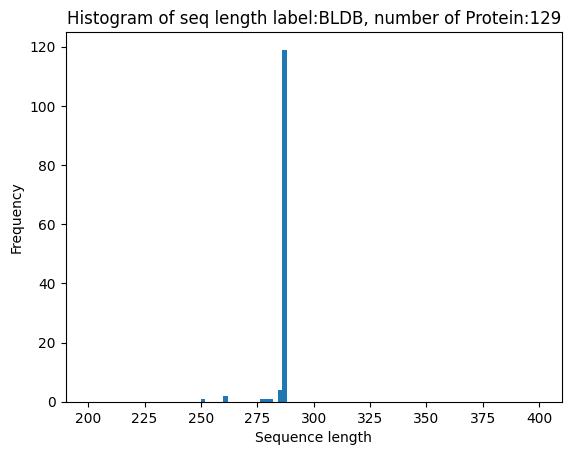

In [25]:
label_type = "Source"
label_value = "DNA_Connection"
label_value = "BLAST_Protein"
# label_value = 'PREDICTED_FROM_DNA'
label_value = "BLDB"
# label_value = "CARD"

node_type = "Protein"
#node_type = "DNA"


# give me a sequence histogram for al the proteins that are annoted by a label source with the value BLAST_Protein
# first get all the proteins that are annotated with the label source and the value BLAST_Protein
query_proteins_annotated_with_blast_protein = f"""
    MATCH (p:{node_type}) WHERE p.{label_type} = '{label_value}' RETURN p.accession_id
"""
proteins_annotated_with_blast_protein = eedb.db.execute_read(query_proteins_annotated_with_blast_protein)
print(f"Number of proteins annotated with {label_value}: {len(proteins_annotated_with_blast_protein)}")

# get the sequence length of the proteins
query_sequence_length_of_proteins_annotated_with_blast_protein = f"""
    MATCH (p:{node_type}) WHERE p.{label_type} = '{label_value}' RETURN p.seq_length
"""
sequence_length_of_proteins_annotated_with_blast_protein = eedb.db.execute_read(query_sequence_length_of_proteins_annotated_with_blast_protein)

sequence_length_of_proteins_annotated_with_blast_protein = [item["p.seq_length"] for item in sequence_length_of_proteins_annotated_with_blast_protein]

# plot the histogram of the sequence length of the proteins
plt.hist(sequence_length_of_proteins_annotated_with_blast_protein, bins=100, range=(200, 400))
plt.title(f"Histogram of seq length label:{label_value}, number of {node_type}:{len(sequence_length_of_proteins_annotated_with_blast_protein)}")
plt.xlabel("Sequence length")
plt.ylabel("Frequency")
plt.show()
plt.close()

In [26]:
# the number of the proteins labeled like the above shoudl include all proteins in the database
# so i want to check if the number of proteins labeled like the above is the same as the total number of proteins in the database
query_total_number_of_proteins = f"""
    MATCH (p:Protein) RETURN count(p)
"""
total_number_of_proteins = eedb.db.execute_read(query_total_number_of_proteins)
print(f"Total number of proteins: {total_number_of_proteins[0]['count(p)']}")


query_proteins_labeled_like_above = f"""
    MATCH (p:Protein) WHERE p.Source IS NOT NULL RETURN p.accession_id
"""
proteins_labeled_like_above = eedb.db.execute_read(query_proteins_labeled_like_above)
print(f"Number of proteins labeled like the above: {len(proteins_labeled_like_above)}")

Total number of proteins: 22513
Number of proteins labeled like the above: 22414


In [27]:
# start deleting all proteins which are labeled DNA_Connection and have a seq_length > 320 or < 250
query_proteins_to_delete = f"""
    MATCH (p:Protein) WHERE p.{label_type} = 'DNA_Connection' AND p.seq_length > 300 RETURN p.accession_id
"""
#proteins_to_delete = eedb.db.execute_read(query_proteins_to_delete)
#proteins_to_delete = [item["p.accession_id"] for item in proteins_to_delete]
#print(f"Number of proteins to delete: {len(proteins_to_delete)}")

#query_delete_proteins = f"""
#    MATCH (p:Protein) WHERE p.accession_id IN {proteins_to_delete} DETACH DELETE p
#"""
#eedb.db.execute_write(query_delete_proteins)


In [28]:
query_how_many_are_complement = """
MATCH (d:DNA) WHERE d.complement = 1 RETURN count(d)
"""
how_many_are_complement = eedb.db.execute_read(query_how_many_are_complement)
print(f"Number of DNA sequences that are complement: {how_many_are_complement[0]['count(d)']}")




2025-08-14 07:59:41,480 - WARNING - Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: complement)} {position: line: 2, column: 23, offset: 23} for query: '\nMATCH (d:DNA) WHERE d.complement = 1 RETURN count(d)\n'


Number of DNA sequences that are complement: 0


In [29]:
query_niklas = """
MATCH (p:Protein) RETURN p.embedding LIMIT 1
"""
niklas = eedb.db.execute_read(query_niklas)
print(f"Number of proteins: {np.array(niklas[0]['p.embedding']).shape}")

Number of proteins: (960,)


In [30]:
# STAND 28.01.2025
# Number of DNA sequences connected to a protein: 24772
# Total number of proteins: 26118
# Total number of DNA sequences: 9981

# Number of DNA sequences connected to a protein: 205630
# Total number of proteins: 206976
# Total number of DNA sequences: 10910